*   **Data Preparation:**
    
    *   Use any small dataset of your choice from `torchvision`, such as CIFAR-10.
    *   Prepare data loaders using `torch.utils.data.DataLoader`.
*   **k-Fold Cross-Validation Implementation:**
    
    *   Create a function that implements k-fold cross-validation.
    *   Split the dataset into k folds, training on k-1 folds, and testing on the remaining fold.
    *   Compute the accuracy of the model for each fold.
*   **Network Definition:**
    
    *   Define a simple neural network with at least one hidden layer using `torch.nn.Module`.
*   **Training and Evaluation:**
    
    *   For each fold, train the model on the training data and evaluate on the validation data.
    *   Report the mean and standard deviation of the accuracy across all folds.

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../')
from images_compose import *

# DATA PREPARATION

## Image transformer

In [3]:
imageTransform = TransformConfig()

In [4]:
composed_train = imageTransform.composed_train
composed_test = imageTransform.composed_test

## Dataset

In [32]:
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = composed_test)

train_dataset_basic = datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
validation_dataset_basic = datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## CUDA

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 4060 Ti


## Image Visualization

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [54]:
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    for i, ax in enumerate(axes.flat):
        image = images[i] / 2 + 0.5
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(class_names[labels[i]]) 
        ax.axis('off')
    plt.show()


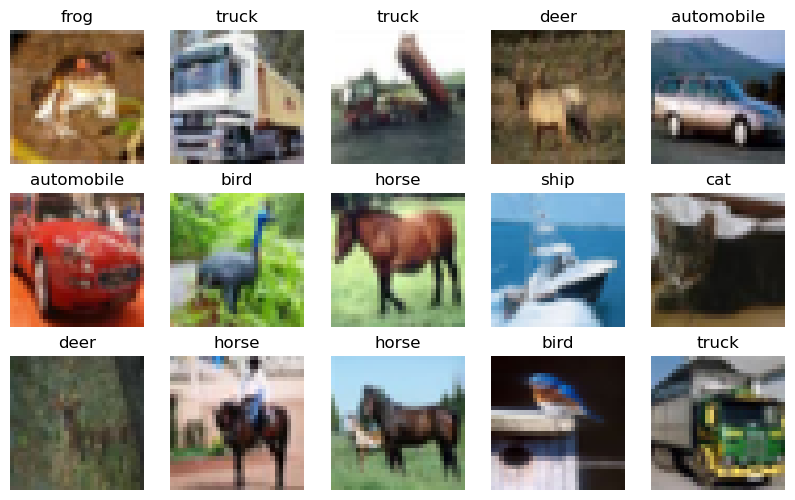

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

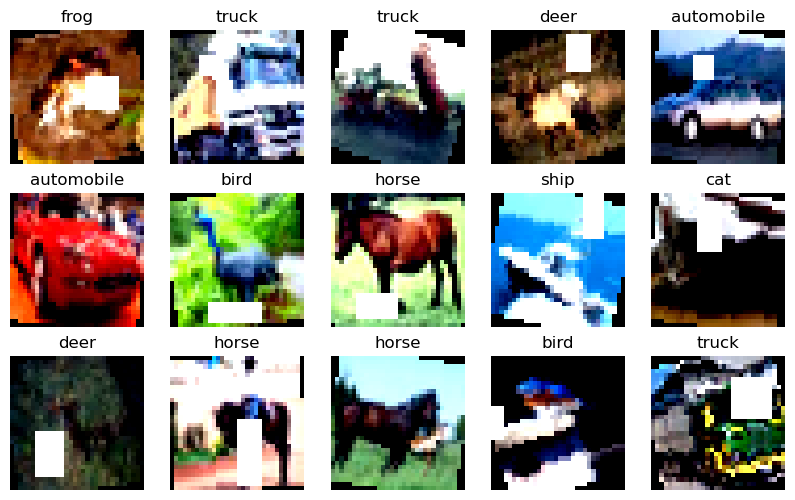

In [66]:
images, labels = [], []
for i in range(15):
    image, label = train_dataset_basic[i]
    images.append(image); labels.append(label)
show_images(images, labels, class_names)

images, labels = [], []
for i in range(15):
    image, label = train_dataset[i]
    images.append(image); labels.append(label)
show_images(images, labels, class_names)



# TRAIN

## K-FOLD

In [69]:
def KFold_Model(model, dataset, optimizer, k = 5, epochs = 5):
  
  kf = KFold(n_splits=k, random_state=56, shuffle=True)
  accuracies = []
  torch.manual_seed(56)

  for train_idx, test_idx in kf.split(dataset):
      train_loader = DataLoader(Subset(dataset, train_idx), batch_size=128, shuffle=True)
      test_loader = DataLoader(Subset(dataset, test_idx), batch_size=128, shuffle=False)

      criterion = nn.CrossEntropyLoss()
      model = model.to(device)
      # Training
      for epoch in range(epochs):
          model.train()
          for images, labels in train_loader:
              images, labels = images.to(device), labels.to(device)
              optimizer.zero_grad()
              outputs = model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

      # Evaluation
      model.eval()
      correct, total = 0, 0
      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      accuracy = 100 * correct / total
      accuracies.append(accuracy)
      print(f'Fold Accuracy: {accuracy}%')

  print(f'Mean Accuracy: {np.mean(accuracies)}%')
  print(f'Standard Deviation: {np.std(accuracies)}%')
  return model

In [92]:
def KFold_Model2(model, dataset, optimizer, k=5, epochs=5, batch_size=128):
    kf = KFold(n_splits=k, random_state=56, shuffle=True)
    accuracies = []
    torch.manual_seed(56)

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset), 1):
        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

        criterion = nn.CrossEntropyLoss()
        model = model.to(device)

        # Training
        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        correct, total = 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Fold {fold} Accuracy: {accuracy}%')

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print(f'Confusion Matrix for Fold {fold}:')
        print(cm)

    mean_accuracy = np.mean(accuracies)
    std_deviation = np.std(accuracies)
    print(f'Mean Accuracy: {mean_accuracy}%')
    print(f'Standard Deviation: {std_deviation}%')

    return model


## Neuronal Networks

In [71]:
from networks import *

In [105]:
model = NN05()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
dataset = train_dataset_basic

trained_model = KFold_Model2(model = model, 
            dataset = dataset,
            optimizer = optimizer,
            k = 3,
            epochs = 5)

Fold 1 Accuracy: 67.40265194696106%
Confusion Matrix for Fold 1:
[[1196   40   34   34   34   13    7   29  206   83]
 [  32 1390    9   14    7    7    9   13  107  144]
 [ 132   25  788  135  158  166  142   77   57   21]
 [  45   17   74  856   72  302  119   70   64   33]
 [  51   14  111  113  916   89  118  169   22   10]
 [  13   13   73  318   73 1008   47   87   21   17]
 [  15   17   67  115   50   51 1271   20   26   26]
 [  31    9   41   96   99  119   13 1201   24   29]
 [  89   59   13   21    9    7    5    4 1391   32]
 [  50  205    7   22    5   18   11   30  108 1217]]
Fold 2 Accuracy: 73.85252294954101%
Confusion Matrix for Fold 2:
[[1210   27   58   21   63   18   21   20  168   45]
 [  23 1432    9    5    8    7   14    7   32  100]
 [  81    9  971   63  228   80  132   54   44   20]
 [  36   11   83  786  138  352  175   70   36   25]
 [  31    7   53   56 1295   49   85   83   17   12]
 [   8    9   72  176   86 1131   90   97   13   21]
 [   9   13   45   49

# EVALUATION

In [82]:
labels = {}
for n in range(1000):
    label = str(validation_dataset[n][1])
    if label in labels:
        labels[label] = int(labels[label])+1
    else:
        labels[label] = 0
print(labels)
        

{'3': 102, '8': 105, '0': 102, '6': 111, '1': 88, '9': 108, '5': 85, '7': 101, '4': 89, '2': 99}


In [103]:
def evaluate_model(model, validation_dataset):
    val_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False)
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Movemos tanto imágenes como etiquetas al dispositivo
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy}%')
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [102]:
for images, labels in val_loader:
    print(images.shape, labels)
    break

NameError: name 'val_loader' is not defined

In [104]:
evaluate_model(trained_model, validation_dataset)

torch.Size([128, 3, 32, 32]) tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])


ZeroDivisionError: division by zero

### Exercise 2: Dropout Regularization

#### Goal

Apply dropout regularization to a neural network to improve its robustness.

#### Instructions

1.  **Data Preparation:**
    
    *   Use the same dataset as in Exercise 1.
2.  **Network Definition:**
    
    *   Define a neural network with multiple layers using `torch.nn.Module`.
    *   Add dropout layers after each hidden layer using `torch.nn.Dropout`.
3.  **Training and Evaluation:**
    
    *   Train the model on the training dataset, evaluating on a separate validation set.
    *   Experiment with different dropout rates (e.g., 0.2, 0.5, 0.7).
    *   Observe how dropout affects the model's performance, especially underfitting and overfitting.
4.  **Analysis:**
    
    *   Plot training and validation accuracy curves for different dropout rates.
    *   Discuss the results, noting any significant changes in accuracy or overfitting.

In [ ]:
class DropoutCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 120)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Function to train and evaluate the model
def train_evaluate(dropout_rate):
    model = DropoutCNN(dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Evaluate for different dropout rates
dropout_rates = [0.2, 0.5, 0.7]
accuracies = [train_evaluate(rate) for rate in dropout_rates]

In [ ]:
print("dropout_rates: ",dropout_rates)
print("accuracies: ",accuracies)

### Exercise 3: L1 Regularization

#### Goal

Implement L1 regularization to constrain model weights and reduce overfitting.

#### Instructions

1.  **Data Preparation:**
    
    *   Use the same dataset as in Exercise 1.
2.  **Network Definition:**
    
    *   Define a neural network with at least one hidden layer using `torch.nn.Module`.
3.  **L1 Regularization Implementation:**
    
    *   Add L1 regularization to the loss function by including the sum of the absolute values of model weights.
    *   Manually calculate the L1 loss and add it to the main loss function.
4.  **Training and Evaluation:**
    
    *   Train the model with and without L1 regularization.
    *   Compare the results in terms of overfitting and weight sparsity.
5.  **Analysis:**
    *   Plot weight histograms to visualize the effect of L1 regularization.
    *   Report accuracy and loss for both regularized and non-regularized models.

In [ ]:
# Network Definition
...

In [ ]:
# L1 Regularization Loss Calculation
...


In [ ]:
# Training and Evaluation with L1 Regularization
...
# Evaluate with and without L1 Regularization
...